# 1D quantum Gradient Echo Memory equations with XMDS2

In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

In [87]:
plt.rcParams["legend.fontsize"] = 6;
plt.rcParams['figure.dpi'] = 120; # Changes figsize to 120% when displayed in notebook

In [17]:
# Load the data from a file
def load_instance(filename):
    with h5py.File(filename, "r") as f:
        dst = f['1'] # Dataset
        t, z, = (dst['t'][:], dst['z'][:])
        S_im, S_re, E_im, E_re = (dst['SI'][:], dst['SR'][:], dst['EI'][:], dst['ER'][:])
        # Indexing with [:] converts from 'dataset' to 'np.ndarray'.
        # Each row corresponds with a time, and each column with a z-position.
        S = S_re + S_im * 1j
        E = E_re + E_im * 1j
        return (t, z, E, S)

In [103]:
# Performance measures
def performance(t,z,E,S, tswitch):
    # This function assumes time samples are evenly spaced.
    # The output pulse is reversed; so we can compare by taking the first
    # switch_index samples *after* switch_index, and reversing that.
    # The input pulse is ignored after t_switch.
    switch_index = int(len(t) * (tswitch - min(t))/(max(t) - min(t)))
    if len(t) < 2*switch_index:
        print("WARNING: duration < 2 * t_switch. Cannot fairly compare pulses.")
        return None, None
    Ein = E[:switch_index,0]
    tin = t[:switch_index]
    Eout = np.flip(E[switch_index:2*switch_index,-1]) # Excludes initial leakage
    # Norm is proportional to energy
    norm_in = simpson(np.power(np.abs(Ein),2), tin)
    norm_out = simpson(np.power(np.abs(Eout), 2), tin)
    efficiency = np.abs(norm_out/norm_in);
    fidelity = np.abs(simpson(np.conj(Ein) * Eout, tin)) / np.sqrt(norm_in * norm_out)
    
    return efficiency, fidelity

In [75]:
# Summary plots of a run
def summary_plot(t,z,E,S, tswitch):
    fig, axs = plt.subplots(2,2)
    (axTL, axTR, axBL, axBR) = (axs[0,0], axs[0,1], axs[1,0], axs[1,1])
    
    # Plot density
    tmin, tmax, zmin, zmax = (min(t), max(t), min(z), max(z))
    imopts = {"cmap":'plasma', "interpolation":'bicubic', 
              "extent":[zmin, zmax,tmin, tmax], "aspect":"auto",
              "origin": "lower"}
    
    ## Probe
    axTL.imshow(np.abs(E), **imopts)
    axTL.set_title("Probe")
    axTL.set_xlabel("z"); axTL.set_ylabel("t")
    axTL.axhline(tswitch, ls="--", color="r")
    
    ## Spinwave
    axTR.imshow(np.abs(S), **imopts)
    axTR.set_title("Spinwave")
    axTR.set_xlabel("z"); axTR.set_ylabel("t")
    axTR.axhline(tswitch, ls="--", color="r")
    
    # Input and output pulses
    axBL.plot(t, np.real(E[:,0]), label = "In (Re)")
    axBL.plot(t, np.real(E[:,-1]), label = "Out (Re)")
    axBL.plot(t, np.imag(E[:,-1]), label = "Out (Im)")
    axBL.axvline(tswitch, ls="--", color="r")
    axBL.set_xlabel("t"); axBL.set_ylabel("Light amplitude")
    axBL.legend()
    axBL.set_title("Input and output pulses")
    
    # Spinwave at t_switch
    switch_index = int(len(t) * (tswitch - tmin)/(tmax - tmin))
    axBR.plot(z, np.abs(S[switch_index, :]))
    axBR.set_title("Spinwave at t_switch")
    axBR.set_xlabel("z"); axBR.set_ylabel("Magnitude")
    
    eff, fid = performance(t,z,E,S,tswitch)
    fig.suptitle(f"Efficiency: {eff:.2f}    Fidelity: {fid:.2f}")
    fig.tight_layout()

In [77]:
# Load datasets
dbl_gauss_pulsewidth1_2 = load_instance("./instances/double-gaussian/pulsewidth=1.2.h5")
tophat = load_instance("./instances/tophat/jesse-tophat.h5")
tophat_long = load_instance("./instances/tophat-longterm/jesse-tophat-long.h5")
triangle = load_instance("./instances/triangle/jesse-triangle.h5")

# TODO: play with bandwidth, pulsewidth, od for original Gaussian
gauss = load_instance("./instances/gaussian/jesse-gaussian.h5")

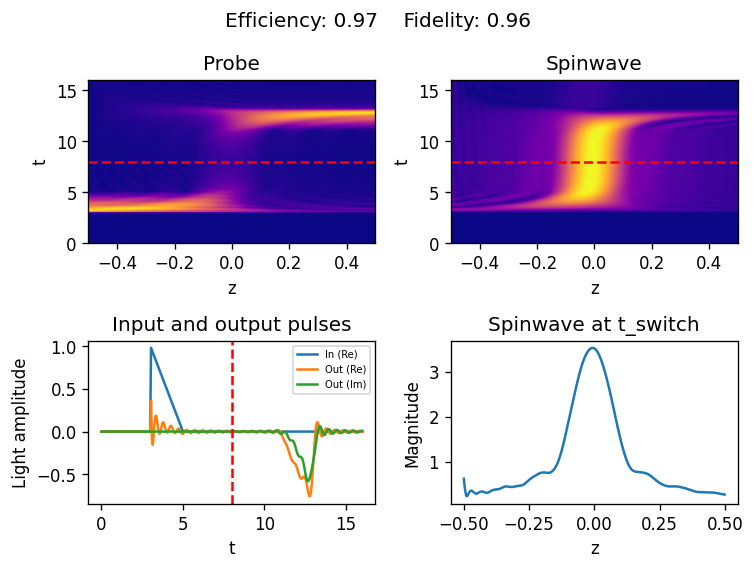

In [104]:
summary_plot(*triangle, 8)

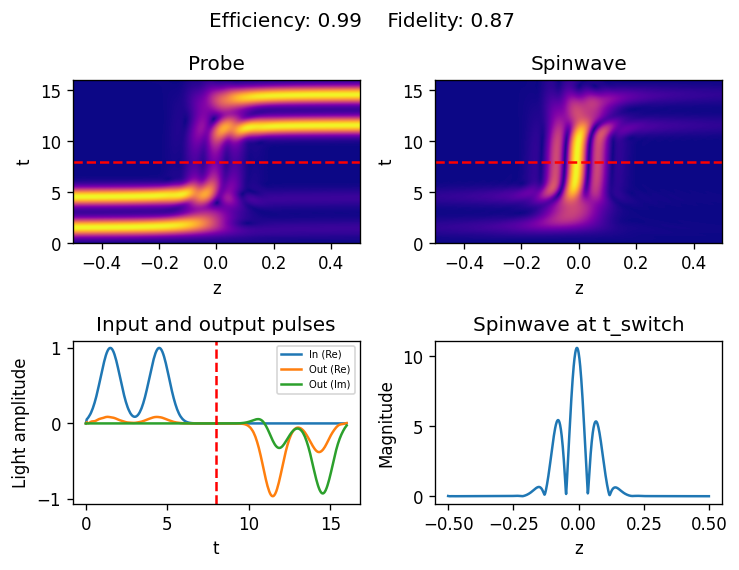

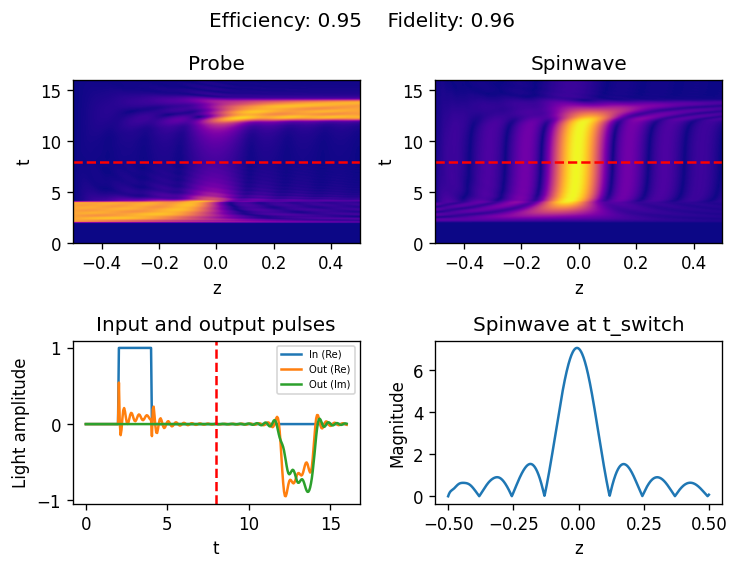

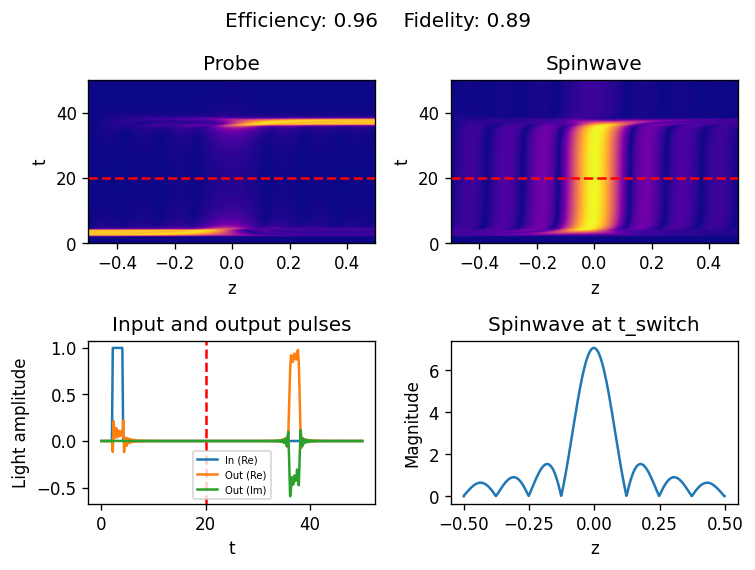

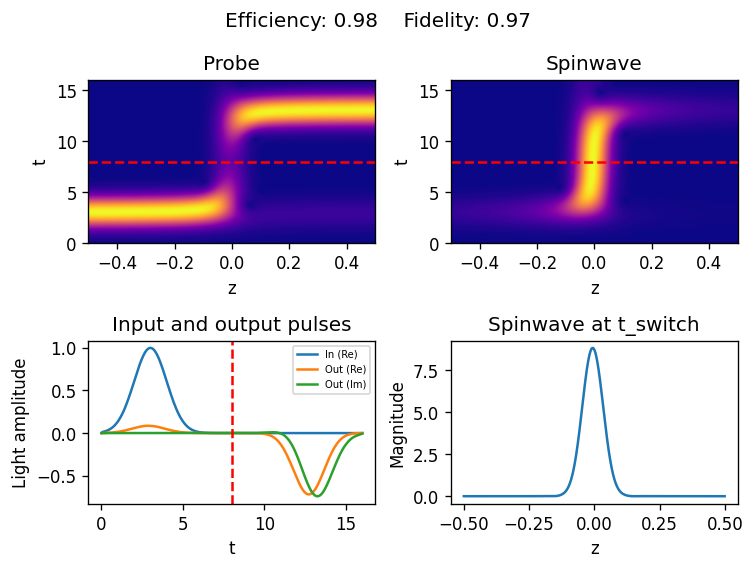

In [105]:
summary_plot(*dbl_gauss_pulsewidth1_2, 8)
summary_plot(*tophat, 8)
summary_plot(*tophat_long, 20)
summary_plot(*gauss, 8)